In [2]:
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
DATA_DIR = Path('dataset')
TRAIN_DIR = DATA_DIR / 'training_set'
TEST_DIR = DATA_DIR / 'test_set'
SEED = 123

In [4]:
# این سلول را اجرا کنید تا فایل‌های خراب حذف و فایل‌های 2-کاناله به RGB تبدیل شوند

import time

DATA_DIR_TO_CHECK = Path('dataset') 
image_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
converted_files = 0
deleted_files = 0

print(f"Scanning, converting, and cleaning: {DATA_DIR_TO_CHECK}")
print("This may take a few minutes...")

for root, dirs, files in os.walk(DATA_DIR_TO_CHECK):
    for file in files:
        file_path = Path(root) / file
        
        if file_path.suffix.lower() not in image_extensions:
            if not file.startswith('.'): 
                try:
                    os.remove(file_path)
                    print(f"[Deleted] Non-image file: {file_path}")
                    deleted_files += 1
                except Exception as e:
                    print(f"[Warning] Could not delete non-image file (likely locked): {file_path}")
            continue
        
        try:
            with Image.open(file_path) as img:
                img.load() 

                if img.mode in ('LA', 'P') or len(img.getbands()) == 2:
                    print(f"[Converting] Found mode '{img.mode}'. Converting to RGB: {file_path}")
                    rgb_img = img.convert('RGB')
                    img.close()
                    rgb_img.save(file_path)
                    converted_files += 1
                
                elif img.mode == 'RGBA':
                    print(f"[Converting] Found mode 'RGBA'. Converting to RGB: {file_path}")
                    rgb_img = img.convert('RGB')
                    img.close()
                    rgb_img.save(file_path)
                    converted_files += 1

        except Exception as e:
            print(f"!! [Deleting] Corrupt Image: {file_path}, Error: {e}")
            try:
                time.sleep(0.1) 
                os.remove(file_path)
                deleted_files += 1
            except Exception as e_del:
                print(f"!! [Error] FAILED to delete corrupt file (still locked?): {file_path}. Error: {e_del}")
                print(f"!! ==> PLEASE DELETE THIS FILE MANUALLY: {file_path}")

print("\n" + "="*30)
print("Dataset cleanup finished.")
print(f"Total files converted to RGB: {converted_files}")
print(f"Total corrupt/non-image files deleted: {deleted_files}")
print("\nRECOMMENDATION: Please RESTART THE KERNEL now before continuing.")

Scanning, converting, and cleaning: dataset
This may take a few minutes...


C:\Users\VIRA\anaconda3\envs\tf-gpu\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Dataset cleanup finished.
Total files converted to RGB: 0
Total corrupt/non-image files deleted: 0

RECOMMENDATION: Please RESTART THE KERNEL now before continuing.


In [4]:
DATA_DIR_TO_CHECK = Path('dataset') 
image_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
bad_files = []

print(f"Starting FINAL cleanup scan using TensorFlow on: {DATA_DIR_TO_CHECK}")
print("This will be slow, but it is guaranteed to find the bad files...")

all_file_paths = []
for root, dirs, files in os.walk(DATA_DIR_TO_CHECK):
    for file in files:
        file_path = Path(root) / file
        if file_path.suffix.lower() in image_extensions:
            all_file_paths.append(str(file_path)) 

total_files = len(all_file_paths)
for i, file_path in enumerate(all_file_paths):
    
    if (i+1) % 200 == 0:
        print(f"Checked {i+1} / {total_files} files...")
        
    try:
        img_bytes = tf.io.read_file(file_path)
        
        img = tf.io.decode_image(img_bytes, channels=3)
        
        img.get_shape()
        
    except Exception as e:
        print(f"\n!! Found Corrupt File: {file_path}")
        print(f"   Error: {e}\n") 
        bad_files.append(file_path)

print("\n" + "="*30)
if bad_files:
    print(f"Scan Finished. Found {len(bad_files)} corrupt files. Deleting them...")
    deleted_count = 0
    for f in bad_files:
        try:
            time.sleep(0.05) 
            os.remove(f)
            deleted_count += 1
        except Exception as e_del:
            print(f"!! FAILED TO DELETE: {f}. Error: {e_del}")
            print(f"!! ==> PLEASE DELETE THIS FILE MANUALLY.")
    print(f"Successfully deleted {deleted_count} files.")
else:
    print("Scan Finished. No corrupt files found by TensorFlow.")

print("\nRECOMMENDATION: Please RESTART THE KERNEL now before continuing.")

Starting FINAL cleanup scan using TensorFlow on: dataset
This will be slow, but it is guaranteed to find the bad files...
Checked 200 / 24986 files...
Checked 400 / 24986 files...
Checked 600 / 24986 files...
Checked 800 / 24986 files...
Checked 1000 / 24986 files...
Checked 1200 / 24986 files...
Checked 1400 / 24986 files...
Checked 1600 / 24986 files...
Checked 1800 / 24986 files...
Checked 2000 / 24986 files...
Checked 2200 / 24986 files...
Checked 2400 / 24986 files...
Checked 2600 / 24986 files...
Checked 2800 / 24986 files...
Checked 3000 / 24986 files...
Checked 3200 / 24986 files...
Checked 3400 / 24986 files...
Checked 3600 / 24986 files...
Checked 3800 / 24986 files...
Checked 4000 / 24986 files...
Checked 4200 / 24986 files...
Checked 4400 / 24986 files...
Checked 4600 / 24986 files...
Checked 4800 / 24986 files...
Checked 5000 / 24986 files...
Checked 5200 / 24986 files...
Checked 5400 / 24986 files...
Checked 5600 / 24986 files...
Checked 5800 / 24986 files...
Checked 6000

In [5]:
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        labels='inferred',
        label_mode='binary',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=0.0, 
        subset=None
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        labels='inferred',
        label_mode='binary',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )
    
    
except Exception as e:
    print("\n\n!!! FAILED TO LOAD DATASET !!!")
    print(f"Error: {e}")
    print("This likely means a bad file still exists.")
    print("Please re-run the cleanup script (Cell 3) and RESTART the kernel.")

Found 21185 files belonging to 2 classes.
Found 3799 files belonging to 2 classes.
Class names found: ['Cat', 'Dog']


In [6]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Dog']


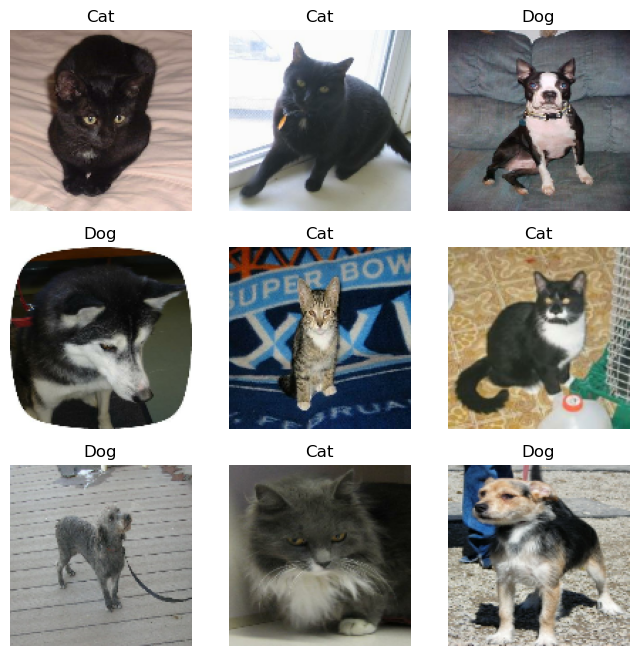

In [7]:
plt.figure(figsize=(8, 8))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[int(label[i])])
        plt.axis('off')
plt.show()

In [8]:
rescale_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08)
], name="data_augmentation")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000, seed=SEED)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, training=True)
test_ds = prepare(test_ds, training=False)

## Build CNN model

In [10]:
def build_model(input_shape=IMG_SIZE+(3,)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation= 'relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation= 'relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Compile

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Callback

In [12]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cats_dogs.h5', save_best_only=True)
]

## model training

In [13]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5694 - loss: 0.6814

663/663 ━━━━━━━━━━━━━━━━━━━━ 120s 152ms/step - accuracy: 0.6238 - loss: 0.6447 - val_accuracy: 0.7205 - val_loss: 0.5389
Epoch 2/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7033 - loss: 0.5746

663/663 ━━━━━━━━━━━━━━━━━━━━ 96s 145ms/step - accuracy: 0.7204 - loss: 0.5527 - val_accuracy: 0.7915 - val_loss: 0.4485
Epoch 3/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7542 - loss: 0.5003

663/663 ━━━━━━━━━━━━━━━━━━━━ 96s 145ms/step - accuracy: 0.7628 - loss: 0.4893 - val_accuracy: 0.8078 - val_loss: 0.4219
Epoch 4/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7858 - loss: 0.4534

663/663 ━━━━━━━━━━━━━━━━━━━━ 95s 144ms/step - accuracy: 0.7961 - loss: 0.4392 - val_accuracy: 0.8192 - val_loss: 0.4027
Epoch 5/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 95s 143ms/step - accuracy: 0.8291 - loss: 0.3781 - val_accuracy: 0.8123 - val_loss: 0.4224
Epoch 6/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 95s 144ms/step - accuracy: 0.8622 - loss: 0.3171 - val_accuracy: 0.7910 - val_loss: 0.4886
Epoch 7/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - accuracy: 0.8886 - loss: 0.2626 - val_accuracy: 0.7781 - val_loss: 0.5658
Epoch 8/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 99s 149ms/step - accuracy: 0.9098 - loss: 0.2183 - val_accuracy: 0.7894 - val_loss: 0.5279
Epoch 9/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 100s 150ms/step - accuracy: 0.9260 - loss: 0.1812 - val_accuracy: 0.8210 - val_loss: 0.4948
Epoch 10/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 103s 155ms/step - accuracy: 0.9401 - loss: 0.1500 - val_accuracy: 0.8155 - val_loss: 0.6186
Epoch 11/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 103s 155ms/step - accuracy: 0.9485 - loss: 0.1326 

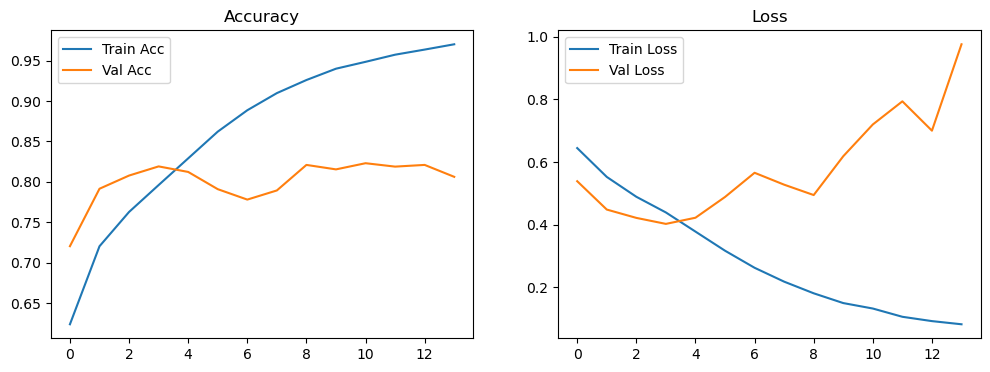

In [14]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [15]:
y_true = np.array([])
y_pred_probs = np.array([])

print("Starting evaluation on test dataset...")
for images, labels in test_ds:
    preds = model.predict(images)
    y_true = np.concatenate([y_true, labels.numpy().astype(int).reshape(-1)])
    y_pred_probs = np.concatenate([y_pred_probs, preds.reshape(-1)])

print("Evaluation finished. Generating reports...")

y_pred = (y_pred_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Starting evaluation on test dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━

In [1]:
def predict_image(image_path, model, img_size=IMG_SIZE, class_names=class_names):
    try:
        img = load_img(image_path, target_size=img_size)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    prob = model.predict(arr)[0][0]
    label_index = int(prob > 0.5)
    label = class_names[label_index]
    
    return prob, label, img

sample_path_str = 'dataset/single_prediction/cat_or_dog_1.jpg' 
sample_path = Path(sample_path_str)

if sample_path.exists():
    prob, label, img = predict_image(str(sample_path), model)
    
    if img:
        plt.imshow(img)
        confidence = prob if label == class_names[1] else 1 - prob
        plt.title(f"Predicted: {label} ({confidence:.2f})")
        plt.axis("off")
        plt.show()
else:
    print(f"File not found: {sample_path}")

NameError: name 'IMG_SIZE' is not defined

In [20]:
model.save('cats_vs_dogs_final.h5')
print("Final model saved to 'cats_vs_dogs_final.h5'")

Final model saved to 'cats_vs_dogs_final.h5'
